In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import scipy as sp
from scipy.stats import norm,kstest,shapiro,t,spearmanr
import warnings
import seaborn as sns
import statistics
warnings.filterwarnings('ignore')

# I created a risk_management package to store all the methods above
from risk_management import cov, psd, simulation, ES, VaR


# Problem1
Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data. Calculate the VaR and ES for both fitted distributions. Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the differences.

In [110]:
data = pd.read_csv("problem1.csv")

In [111]:
# Normal Distribution
mu = data.mean()
sig = data.std()
alpha = 0.05
VaR_norm = norm.ppf(alpha)*sig + mu
print(f"Normal distribution 95% VaR is {round(-VaR_norm[0]*100,2)}%")
ES_norm = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig - mu
print(f"Normal distribution 95% ES is {round(ES_norm[0]*100,2)}%")

Normal distribution 95% VaR is 8.13%
Normal distribution 95% ES is 10.18%


In [112]:
# T Distribution by MLE fit
def t_log_lik(par_vec, x):
    lik = -np.log(t(df = par_vec[0],loc=par_vec[1],scale = par_vec[2]).pdf(x)).sum()
    return lik
cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2},
            {'type': 'ineq', 'fun': lambda x:  x[2]})

import scipy.optimize as optimize
# optimize the params
df, mean ,scale = optimize.minimize(fun = t_log_lik, 
                            x0 = [2, np.array(data).mean(), np.array(data).std()],
                            constraints=cons,
                            args = (np.array(data))).x

In [114]:
VaR_t = scale * t.ppf(alpha, df)
print(f"T distribution params are degree of freedom:{round(df,2)},mean:{round(mean,2)}  sigma:{round(scale,2)}")
print(f"T distribution 95% VaR: {round(-VaR_t*100,2)}%") 

simu_T =  t.rvs(loc = mean,df = df,scale = scale,size = 1000000)
VaR_t = -np.percentile(simu_T,5)
return_before_alpha = simu_T[simu_T < -VaR_t]
ES_t = return_before_alpha.mean()
print(f"T distribution 95% ES: {round(-ES_t*100,2)}%") 

T distribution params are degree of freedom:4.25,mean:-0.0  sigma:0.04
T distribution 95% VaR: 7.64%
T distribution 95% ES: 11.34%


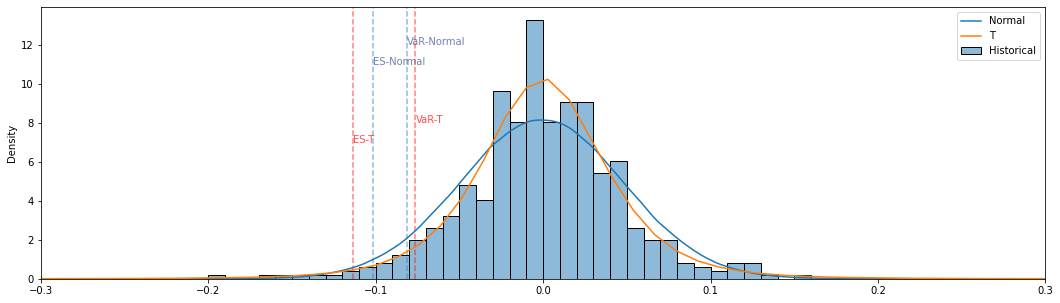

In [11]:
# Discuss the ability of these models to describe the risk in this stock.
simu_norm =  norm.rvs(mu,sig,size = 1000000)
fig, axes = plt.subplots(figsize=(18,5))
axes.axvline(x = VaR_norm[0], linestyle='dashed', alpha=0.5)
axes.text(x=VaR_norm[0], y=12, s='VaR-Normal', alpha=0.7, color='#334f8d')
axes.axvline(x = -ES_norm[0], linestyle='dashed', alpha=0.5)
axes.text(x=-ES_norm[0], y=11, s='ES-Normal', alpha=0.7, color='#334f8d')

axes.axvline(x = -VaR_t, linestyle='dashed', alpha=0.5, color='r')
axes.text(x=-VaR_t, y=8, s='VaR-T', alpha=0.7, color='r')
axes.axvline(x = ES_t, linestyle='dashed', alpha=0.5, color='r')
axes.text(x=ES_t, y=7, s='ES-T', alpha=0.7, color='r')

sns.histplot(data, binrange = (-.2,.2),binwidth = 0.01,stat='density',ax=axes, label='Historical', color='b', alpha=0.5)

sns.distplot(simu_norm, ax=axes, hist=False, label='Normal')
sns.distplot(simu_T, ax=axes, hist=False, label='T')

plt.xlim(-0.3, 0.3)
axes.legend()


# Conclusion for problem 1
When Fitting a Normal Distribution for this return series, the VaR is 8.13%, and ES is 10.18%. In the fitting of 
Generalized T distribution, the VaR is 7.64% and the ES is 11.34%. As shown in the figure, T distribution has a lower VaR than Normal Distribution, but higher ES. 

Because the T-distribution has more fat-tail and sharp-peak characteristics than the normal distribution. Therefore, more tail risk information will be included in the T-Distribution of risks, resulting in a larger ES. And most of the return is around the mean, leading to a smaller VaR.


# Problem 2
In your main repository, create a Library for risk management. Create modules, classes, packages, etc as you see fit. Include all the functionality we have discussed so far in class. 
Make sure it includes:
1. Covariance estimation techniques. 
2. Non PSD fixes for correlation matrices 
3. Simulation Methods 
4. VaR calculation methods (all discussed) 
5. ES calculation

Create a test suite and show that each function performs as expected.

In [120]:
# I created a risk_management package to store all the methods above
from risk_management import cov, psd, simulation, ES, VaR

## 1. Covariance estimation techniques.

In [221]:
# Calculate the weighted Cov
lamb = [0.1, 0.3, 0.5, 0.75, 0.90, 0.97, 0.99]
weights = []
for la in lamb:
    # cov.weighted_cov is to create a weighted cov model
    cov_mat = cov.weighted_cov(la, data)
    weights.append(cov_mat)
weights

[array([[0.00117606]]),
 array([[0.00146402]]),
 array([[0.00174192]]),
 array([[0.00193194]]),
 array([[0.00236758]]),
 array([[0.00301315]]),
 array([[0.00286852]])]

## 2. Non PSD fixes for correlation matrices

In [13]:
# Test for my chol_psd function with np.linalg.cholesky function
A = np.array([[4, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
    
expected_L = np.linalg.cholesky(A)

# psd.chol_psd(A) is the function in the risk_management package
chol_psd_L = psd.chol_psd(A)

if abs(expected_L - chol_psd_L).sum() < 1e-8:
    print("Congrats! The chol_psd function shows the same solution with the cholesky function in numpy.")
    print(chol_psd_L)


Congrats! The chol_psd function shows the same solution with the cholesky function in numpy.
[[ 2.          0.          0.          0.        ]
 [ 1.5         1.93649167  0.          0.        ]
 [ 2.          1.03279556  2.22111083  0.        ]
 [ 4.         -2.5819889   0.75037528  1.33051504]]


In [14]:
def generate_nonpsd_matrix(n):
    corr = np.full((n,n),0.9)
    np.fill_diagonal(corr, 1)
    corr[0,1] = 0.7357
    corr[1,0] = 0.7357 
    return corr

corr = generate_nonpsd_matrix(100)
corr
# psd.Higham_near_psd(corr) and psd.near_psd(corr) are the functions in the risk_management package
near_corr1 = psd.Higham_near_psd(corr)
near_corr2 = psd.near_psd(corr)
print("The loss of Higham method for nearest psd is :", psd.Frobenius_norm(near_corr1-corr))
print("The loss of Rebonato_Jackel method for nearest psd is :", psd.Frobenius_norm(near_corr2-corr))

The loss of Higham method for nearest psd is : 0.007164374540475336
The loss of Rebonato_Jackel method for nearest psd is : 0.07441520643489381


## 3. Simulation Methods

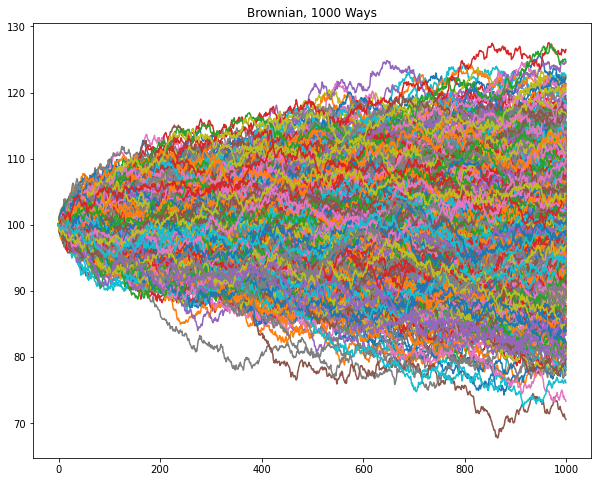

In [15]:
# test the Class of PriceSimulation, it has 3 types of simulations
simulation1 = simulation.PriceSimulation(path=1000, method='Brownian', s0=100, known_step=0, n_step=1000, mu=0, sigma=0.3)
simulation1.data
simulation.plot_simulation(simulation1)

## 4. VaR calculation methods (all discussed)

In [126]:
# the VaR package includes 4 VaR calculation methods: noram, EW norm, T and Historcal
df = pd.read_csv("DailyPrices.csv")
ret = VaR.return_calculate(df["INTC"])
ret -= ret.mean()
ret = pd.DataFrame(ret)
sigma = ret.std()

VaR1 = VaR.VaR_normal(ret, alpha=0.05)
VaR2 = VaR.VaR_EWnorm(ret, alpha=0.05)
VaR3 = VaR.VaR_T(ret, alpha=0.05)
VaR4 = VaR.VaR_Historic(ret, alpha=0.05)
print(f"Normal distribution VaR: {round(VaR1*100,2)}%")
print(f"Exponentially Weighted Normal VaR: {round(VaR2*100,2)}%")
print(f"T distribution VaR: {round(VaR3*100,2)}%")
print(f"Historic Simulation VaR: {round(VaR4*100,2)}%")

Normal distribution VaR: 3.44%
Exponentially Weighted Normal VaR: 2.67%
T distribution VaR: 2.63%
Historic Simulation VaR: 2.07%


## 5. ES calculation

In [139]:
# calculate the ES
df, mean, scale = simulation.Return_T_params(ret)
simulated = t.rvs(df, mean, scale, size=1000)
# ES is the Expected shortfall calculation method in the package
es = ES.ES(simulated)
print(f'The expected shortfall of the return is {round(es*100,2)}%')

The expected shortfall of the return is 3.74%


# Problem 3
Use your repository from #2. Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0. This file contains the stock holdings of 3 portfolios. You own each of these portfolios. Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your total VaR and ES. Compare the results from this to your VaR form Problem 3 from Week 4.

In [97]:
def copula_t_simulation(ret, nOfDarws):
    '''
    Params: ret should be the rate of return
    nOfDarws: # simulations
    '''
    n=ret.shape[1]
    stock_cdf = pd.DataFrame()
    t_params = []

    for col in ret.columns:
        ret[col] -= ret[col].mean()
        df, mean, scale = simulation.Return_T_params(ret[col])
        t_params.append([df, mean, scale])
        stock_cdf[col] = t.cdf(ret[col], df=df, loc=mean, scale=scale)

    numOfDraw=1000
    Corr_spearman = sp.stats.spearmanr(stock_cdf)[0]

    cholesky = psd.chol_psd(Corr_spearman)
    simuNormal = pd.DataFrame(sp.stats.norm.rvs(size=(n,nOfDarws)))
    simulatedT= (cholesky @ simuNormal).T

    Simu_data = pd.DataFrame()
    for i in range(n):
        simu = norm.cdf(simulatedT.iloc[:, i])
        Simu_data[ret.columns[i]] = t.ppf(simu, df=t_params[i][0], loc=t_params[i][1], scale=t_params[i][2])

    return Simu_data


In [108]:
port = pd.read_csv("Portfolio.csv")
port[port["Portfolio"]=="A"]
total = port.groupby('Stock').sum('Holding')
total['Portfolio'] = 'total'
total.reset_index(inplace=True)
port = port.append(total)

prices = pd.read_csv("DailyPrices.csv",index_col=0)
ret_all = VaR.return_calculate(prices,reset_index=False)
current = pd.DataFrame({"Price":prices.iloc[-1]})

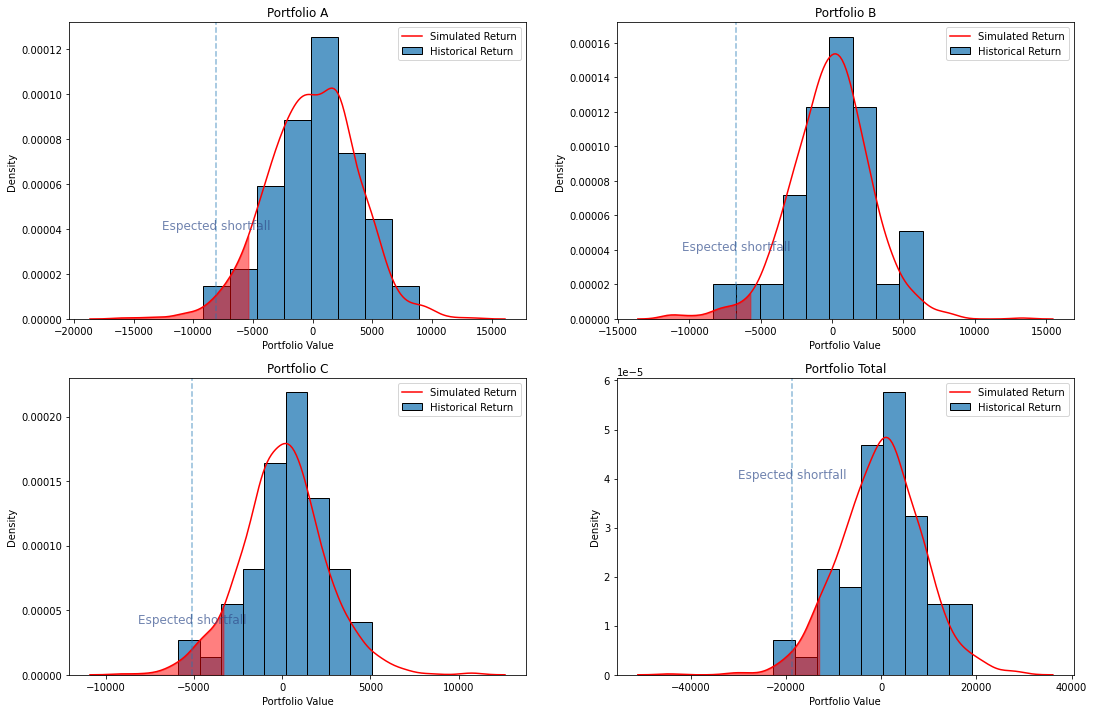

In [210]:
title = ["A","B","C","Total"]
VaR_simu = []
ES_simu = []
VaR_his = []
ES_his = []
i=0

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for port_name, port_data in port.groupby('Portfolio'):
    port_data = port_data.set_index('Stock')
    port_data = port_data.join(current.loc[port_data.index])
    port_data['Value'] = port_data['Holding'] * port_data['Price']

    port_value = port_data['Value'].sum()
    
    
    SimuPortfolio_ret = ret_all[port_data.index]
    ret_MC = copula_t_simulation(SimuPortfolio_ret, 1000)
    
    # calculate the profit&loss based on the simulated return
    profitLoss=ret_MC*port_data['Value']
    Portfolio_Loss = profitLoss.sum(axis=1)
    
    # calculate the simulated VaR
    VaR_p = VaR.VaR_Historic(Portfolio_Loss)
    VaR_simu.append(VaR_p)
    
    # calculate the simulated ES
    ES_p = ES.ES(Portfolio_Loss)
    ES_simu.append(ES_p)
    
    # calculate the historical return
    his_return=port_data['Value']*ret_all[port_data.index]
    his_profitloss = his_return.sum(axis=1)
    
    # calculate the historical VaR
    VaR_h = VaR.VaR_Historic(his_profitloss)
    VaR_his.append(VaR_h)
    
    # calculate the historical ES
    ES_h = ES.ES(his_profitloss)
    ES_his.append(ES_h)
    
    # plot distributions
    ax = axes[i//2][i%2]
    
    sns.histplot(his_profitloss, ax=ax, stat='density', label='Historical Return')
    sns.distplot(Portfolio_Loss, ax=ax, hist=False, label='Simulated Return',color = 'r')
    ax.set_title(f"Portfolio {title[i]}")
    ax.set_xlabel("Portfolio Value")
    ax.legend()
    
    # plot VaR
    ret, ret_density = ax.lines[0].get_data()
    ax.fill_between(ret, ret_density, where=(ret<-VaR_h), color='r', alpha=0.5)
    ax.axvline(x = -ES_p, linestyle='dashed', alpha=0.5)
    ax.text(x=-ES_p, y=0.00004, s='Expected shortfall', fontsize=12,alpha=0.7, color='#334f8d',horizontalalignment='center')

    i+=1

    
    


In [213]:
round(pd.DataFrame({"MC VaR":VaR_simu,
             "MC ES":ES_simu,
             "Historical VaR":VaR_his,
             "Historical ES":ES_his},index =title).T,2)

,A,B,C,Total
MC VaR,6208.73,4644.33,3982.16,14286.87
MC ES,8054.46,6707.61,5089.39,18614.35
Historical VaR,5329.25,5579.83,3320.22,12593.87
Historical ES,7622.93,7231.08,4881.32,19735.33


## Conclusion for problem 3
VaR calculated by the Copula model shows similar VaR values for week 4. But the Copula model is a better fit, because not all stock returns follow the exact standard normal distribution.